In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization # Normalização nos dados e acelerar o desempenho da rede neural

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parâmetros

In [2]:
# Parâmetros gerais
entrada = '../input/leishmaniose-lamina/'

saida = './leishmaniose/'
train_dir = saida + "train/"
val_dir = saida + "val/"
test_dir = saida + "test/"

img_size = (224, 224) # tamanho da imagem de entrada
batch_size = 10

# Parâmetros treinamento
epocas_treinamento = 20
learning_rate = 0.0001

# Funções

In [3]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Divide as imagens em treino, validação e teste
import os
import shutil
import splitfolders
    
# Remove o diretorio caso exista (antes de criá-lo)
if os.path.exists(saida) and os.path.isdir(saida):
    shutil.rmtree(saida)

# Divisão entre treino, validaçao e teste (60%, 10%, 30%)
splitfolders.ratio(entrada, output="leishmaniose", seed=None, ratio=(.6, .1, .3), group_prefix=None) # default values

Copying files: 151 files [00:00, 853.35 files/s]


In [5]:
# Leitura dos dados

from tensorflow import data

# Dados de treino
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size)

# Dados de validação
validation_dataset = image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size)

# Dados de teste
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size)

# Nome da classe
class_names = train_dataset.class_names

# pré-busca em buffer para carregar imagens do disco sem que o I/O se torne um bloqueio
AUTOTUNE = data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 90 files belonging to 2 classes.
Found 14 files belonging to 2 classes.
Found 47 files belonging to 2 classes.


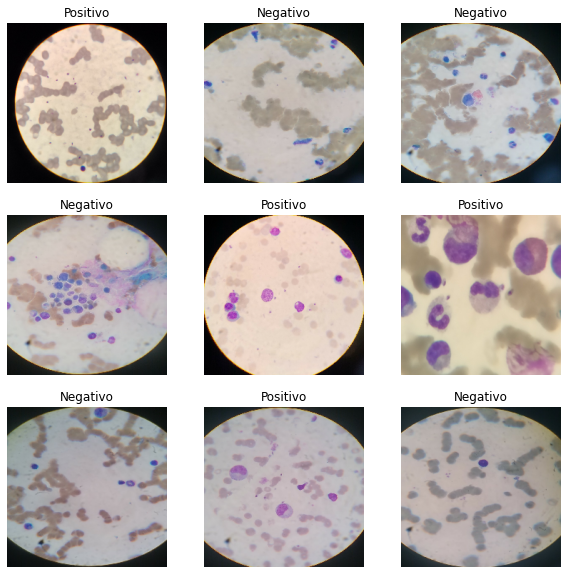

In [6]:
# Visualiza os dados de leitura
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Construir modelo
    
# -------------------- CNN ---------------------

# cria o classificador
model = Sequential()

# -------------------- Primeira camada de convolução ---------------------

# Primeira camada de convolução
# 64 kernels para extrair o mapa de características
# 3x3 --> tamanho do detector de caraterísticas (matriz com 9 pixels)
# input_shape --> dimensões da imagem de entrada
# activation --> função de ativação aplicada ao mapa de característica
model.add(Conv2D(64, (3,3), input_shape=img_size + (3,), activation = 'relu'))

# Normalização
# Normalização dos dados na primeira camada de convolução
# A normalização é realizada no mapa de características (valores entre 0 e 1)
# Acelera o processamento. Pega o mapa de características e normaliza com valores entre 0 e 1
model.add(BatchNormalization())

# Pooling
# 1ª Pooling (max pooling) --> janela 2x2 do max polling
model.add(MaxPooling2D(pool_size = (2,2)))

# -------------------- Segunda camada de convolução ---------------------

# Segunda camada convolucional
# O input_shape é necessário apenas na primeira camada convolucional
model.add(Conv2D(64, (3,3), activation = 'relu'))

# Normalização dos dados na segunda camada de convolução (mapa de característica)
model.add(BatchNormalization())

# Polling
# 2ª Pooling (max pooling) --> janela 2x2 do max polling
model.add(MaxPooling2D(pool_size = (2,2)))

# Flatening na última camada de convolução (no caso, a segunda camada convolucional)
model.add(Flatten())


# -------------------- Rede Neural Densa tradicional ---------------------

# Quantidade de neurônios na camada oculta === 128
model.add(Dense(units = 128, activation = 'relu'))

# Valores zerados na primeira camada oculta (20%)
model.add(Dropout(0.2))

# Camada de saída com 1 neurônio utilizando a função de ativação sigmoid
model.add(Dense(units = 1, activation = 'sigmoid'))

In [8]:
from tensorflow_addons.metrics.cohens_kappa import CohenKappa
from tensorflow_addons.metrics.f_scores import F1Score

# Compile o modelo antes de treiná-lo
    
metricas = [  
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    F1Score(num_classes=2, threshold=0.5, average='micro', name='f1_score'),
    CohenKappa(num_classes=2, name='cohen_kappa')
]

# Compilar modelo
# Não especifiquei o batch_size, pois os dados já estão em conjuntos (batchs)
model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
              loss=keras.losses.BinaryCrossentropy(), # retirei o parâmetro from_logits=True para utilizar a função de ativação sigmoid
              metrics=metricas) # A lista de métricas só funciona caso informe a função de ativação ao compilar o modelo

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0

In [9]:
# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=epocas_treinamento,
                    validation_data=validation_dataset,
                    verbose=1)

Epoch 1/20
9/9 [==============================] - 6s 201ms/step - loss: 1.2773 - tp: 19.6000 - fp: 7.7000 - tn: 18.6000 - fn: 8.1000 - accuracy: 0.6624 - precision: 0.6652 - recall: 0.6351 - f1_score: 0.6476 - cohen_kappa: 0.3213 - val_loss: 46.0467 - val_tp: 7.0000 - val_fp: 7.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1_score: 0.6667 - val_cohen_kappa: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 1s 46ms/step - loss: 0.5891 - tp: 25.7000 - fp: 1.7000 - tn: 22.8000 - fn: 3.8000 - accuracy: 0.9140 - precision: 0.9530 - recall: 0.8875 - f1_score: 0.9184 - cohen_kappa: 0.8272 - val_loss: 0.3951 - val_tp: 6.0000 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.9286 - val_precision: 1.0000 - val_recall: 0.8571 - val_f1_score: 0.9231 - val_cohen_kappa: 0.8571
Epoch 3/20
9/9 [==============================] - 1s 48ms/step - loss: 0.0531 - tp: 27.3000 - fp: 0.4000 - tn: 25.90

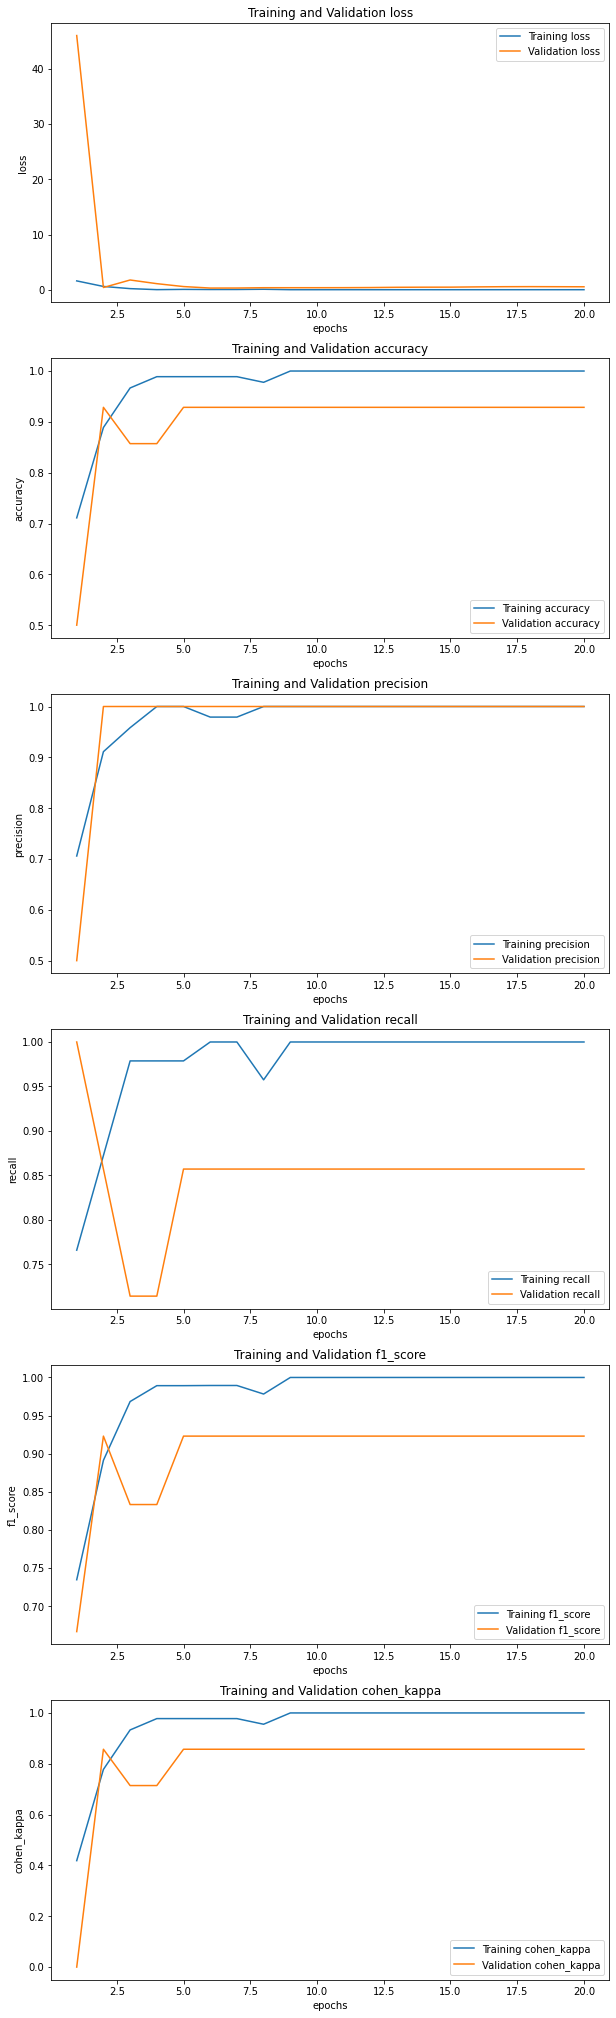

In [10]:
# Curvas de aprendizado da precisão / perda de treinamento e validação ao usar o modelo
metricas_graficos = ["loss", "accuracy", "precision", "recall", "f1_score", "cohen_kappa"]

fig, ax = plt.subplots(len(metricas_graficos), 1, figsize=(10, len(metricas_graficos)*6))
ax = ax.ravel()
dados_x = np.arange(1, epocas_treinamento+1, 1)

for i, met in enumerate(metricas_graficos):        
    ax[i].plot(dados_x, history.history[met], label='Training ' + met)
    ax[i].plot(dados_x, history.history["val_" + met], label='Validation ' + met)
    ax[i].set_title("Training and Validation %s" %(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)

    if (i != 0): # loss function
        ax[i].legend(loc='lower right')
    else:
        ax[i].legend(loc='upper right')

In [11]:
# Avaliação do modelo 
# Não especifiquei o batch_size, pois os dados já estão em conjuntos (batchs)
model.evaluate(test_dataset, verbose=1)

5/5 [==============================] - 1s 20ms/step - loss: 2.0651 - tp: 16.0000 - fp: 1.0000 - tn: 21.0000 - fn: 9.0000 - accuracy: 0.7872 - precision: 0.9412 - recall: 0.6400 - f1_score: 0.7619 - cohen_kappa: 0.5819


[2.065051794052124,
 16.0,
 1.0,
 21.0,
 9.0,
 0.7872340679168701,
 0.9411764740943909,
 0.6399999856948853,
 0.7619047164916992,
 0.581850528717041]

Predictions:
 [0 1 0 1 0 1 0 1 0 0]
Labels:
 [1 1 1 1 0 1 0 1 1 0]


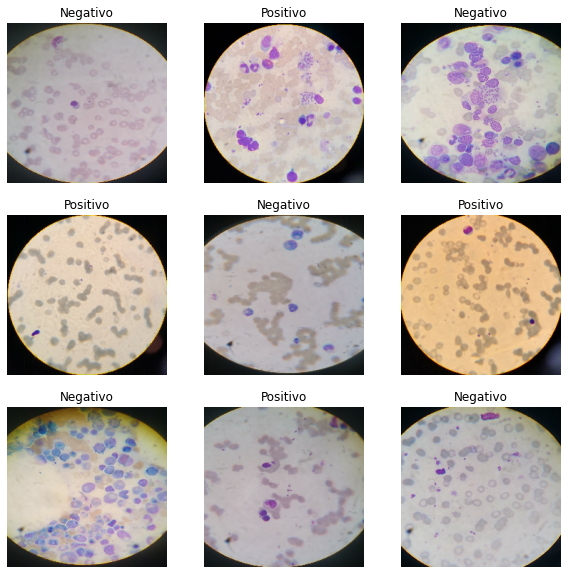

In [12]:
from tensorflow import nn, where

# Recupera um lote de imagens do conjunto de teste
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aplique um sigmóide uma vez que nosso modelo retorna logits
# predictions = nn.sigmoid(predictions) # Funcao sigmoid já aplicada
predictions = where(predictions < 0.5, 0, 1) # Limiar

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")